In [1]:
import torch
import torchsummary
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import os
from PIL import Image
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from torchviz import make_dot
from torchsummary import summary as su
from tqdm import tqdm

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

全局变量

In [2]:
# 所有待预测图像所在的文件夹路径：
pre_doc_loc=r'D:/COSMOS2020/Full_area_COSMOS2020/data_jpg/'
#所有待预测图像名称的.txt文档
pre_name='D:/COSMOS2020/Full_area_COSMOS2020/待预测.txt'
# 结果导出位置：
c='./'

In [4]:
plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(84),
        # transforms.CenterCrop(84),
        # 转换成tensor向量
        transforms.ToTensor(), # 归一化
        transforms.Normalize([0.5], [0.3])
    ]),
    'val': transforms.Compose([
        transforms.Resize(84),
       # transforms.CenterCrop(84),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.3])
    ]),
}

# 图像读入
def Load_Image_Information(path):
    # 图像存储路径，训练集，测试集涉及到的所有带标签的图像
    #image_Root_Dir= r'D:/COSMOS 2015 cataloge/2/cataloge/data/model/image_model'
    image_Root_Dir = train_test_img_loc
    # 获取图像的路径
    iamge_Dir = os.path.join(image_Root_Dir, path)
    # 以L格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    return Image.open(iamge_Dir).convert('L')


class my_Data_Set(nn.Module):
    def __init__(self, txt, transform=None, target_transform=None, loader=None):
        super(my_Data_Set, self).__init__()
        fp = open(txt, 'r') # 打开存储图像名与标签的txt文件
        # fp = open('D:/download_By_Chome/data/acs_mosaic_2.0/index/index.txt', 'r')
        images = []
        labels = []
        # 将图像名和图像标签对应存储起来
        for line in fp:
            line.strip('\n')
            line.rstrip()
            information = line.split()
            images.append(information[0]+' '+information[1])
            labels.append(int(information[2]))
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # 重写这个函数用来进行图像数据的读取
    def __getitem__(self, item):    # 实例对象通过[]运算符取值时，会调用它的方法__getitem__
        # 获取图像名和标签
        imageName = self.images[item]
        label = self.labels[item]
        # 读入图像信息
        image = self.loader(imageName)
        # 处理图像数据
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # 重写函数，查看数据集中含有多少数据
    def __len__(self):
        return len(self.images)


# 定义CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1,18,5)  # layers,feature,size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 16, 5)

        self.fc1 = nn.Linear(16 * 18 * 18,518)
        self.fc2 = nn.Linear(518, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [25]:
# 读取模型
net=Net()
net = net.cuda()
# state_dict = torch.load('D:/COSMOS2020/pycharm_projects/CNN_model_v2_17_13.pth')
state_dict = torch.load('D:/COSMOS2020/pycharm_projects/CNN_model_v2_27_14_00.pth') # 10.95 %
# state_dict = torch.load('D:/COSMOS2020/pycharm_projects/CNN_model_v2_27_new.pth')     # 16 %
net.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [26]:
# 图像读入
class Data_Set(nn.Module):
    def __init__(self, txt, transform=None, target_transform=None, loader=None):
        super(Data_Set, self).__init__()
        # 打开存储图像名与标签的txt文件
        fp = open(txt, 'r')
        images = []
        labels = []
        # 将图像名和图像标签对应存储起来
        for line in fp:
            line.strip('\n')
            line.rstrip()
            information = line.split()
            images.append(information[0])
            labels.append(int(information[1]))
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # 重写这个函数用来进行图像数据的读取
    def __getitem__(self, item):    # 实例对象通过[]运算符取值时，会调用它的方法__getitem__
        # 获取图像名和标签
        imageName = self.images[item]
        label = self.labels[item]
        # 读入图像信息
        image = self.loader(imageName)
        # 处理图像数据
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # 重写函数，查看数据集中含有多少数据
    def __len__(self):
        return len(self.images)

def Load_Image(path):
    # 图像存储路径
    image_Dir= pre_doc_loc     # 所有待预测图像所在的文件夹路径
    # 获取图像的路径
    iamge_Dir = os.path.join(image_Dir, path)
    # 以L格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    return Image.open(iamge_Dir).convert('L')

# 目标数据
obj_dataset = Data_Set(pre_name, transform=data_transforms['val'], loader=Load_Image)     #所有待预测图像名称.jpg
obj_loader = DataLoader(obj_dataset, batch_size=10, shuffle=True)
prediction=[]

with torch.no_grad():
    for data in tqdm(obj_loader):
        images, labels = data

        images,labels = images.to(device),labels.to(device)

        outputs = net(Variable(images))
        __, predicted = torch.max(outputs.data, dim=1)

        # total += labels.size(0)
        # correct += (predicted == labels).sum()
        prediction.append(predicted)
pre=[]
for i in range(len(prediction)):
    for j in range(len(prediction[i])):
        pre.append(int(prediction[i][j]))


count=0
for i in range(len(pre)):
    if pre[i]==1:
        count+=1
# print(count/len(pre))

print('在 {} 个图像中识别出 {} 个merger，占比 {:.2f} %'.format(len(pre),count,100*(count/len(pre))))

100%|██████████| 3843/3843 [01:55<00:00, 33.13it/s]


在 38424 个图像中识别出 4207 个merger，占比 10.95 %


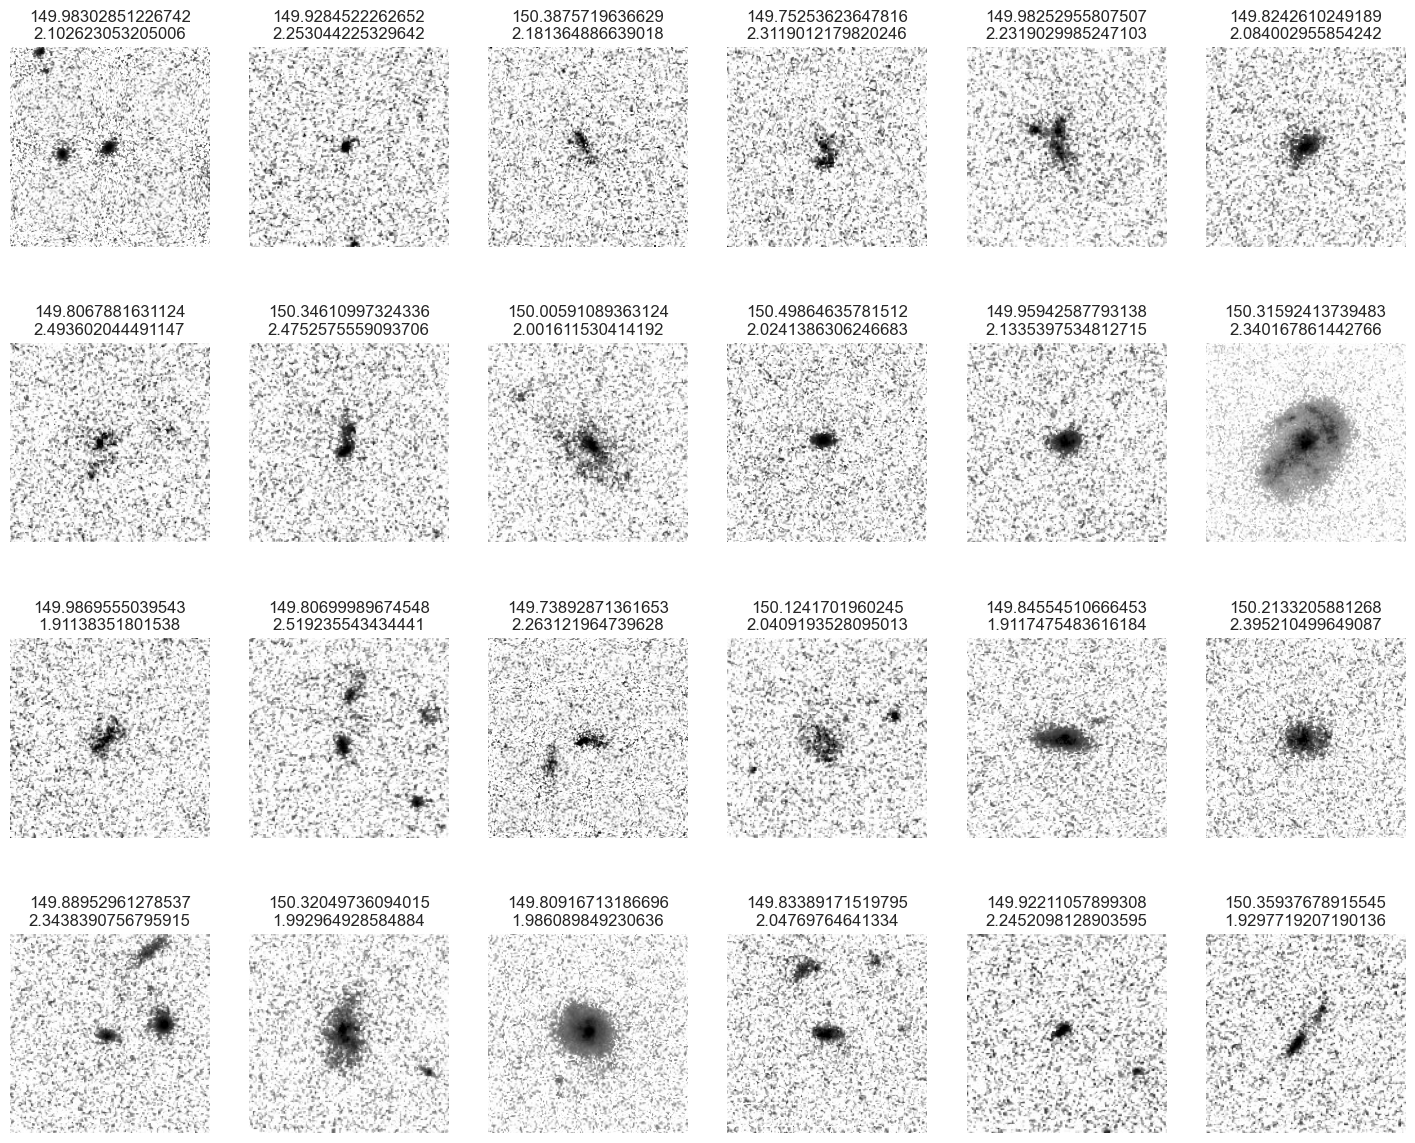

In [32]:
loc = pre_doc_loc   # 所有待预测图像所在的文件夹路径

# 输出列表merger
lis=os.listdir(loc)   # 所有待预测图像所在的文件夹路径
merger=[]
for i in range(len(pre)):
    if pre[i]>0:
        merger.append(lis[i])
fig = plt.figure(figsize=(18,15),dpi=100)




for i in range(24):
    ax=fig.add_subplot(4,6,i+1)
    lo=merger[np.random.randint(1,len(merger))]
    img_path =loc # 所有待预测图像所在的文件夹路径
    image=plt.imread(img_path+lo)
    ax.imshow(image,cmap='rocket')
    s=lo.split('_',)
    ax.set_title('{}\n{}'.format(s[1],s[2]))
    ax.axis('off')

plt.savefig('im_show.png',dpi=90)
plt.show()

In [35]:
ra,dec=[],[]
for j in merger:
    s=j.split('_')
    r=s[1]
    d=s[2]
    ra.append(r)
    dec.append(d)
RA,DEC=np.array(ra),np.array(dec)
condinate=np.stack((RA,DEC),axis=1)

# 将识别的merger导出为.csv
merger=pd.DataFrame(condinate)
merger.to_csv('./merger_condinate.csv',index=False)

CNN模型可视化

In [24]:
# outputs = net(inputs)
# g = make_dot(outputs)
# g.render('espnet_model', view=False) # 会自动保存为一个 espnet.pdf，第二个参数为True